In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as spi
import matplotlib.pyplot as plt
from scipy import sparse
import h5py
import PIL.Image
import pandas

%matplotlib notebook

# Calcul du Laplacien en 2D 

In [2]:
## Generate the Discrete Laplacians based on French grid

f2 = h5py.File('grid_2.hdf5', 'r') #load the grid generated with ../datasets/generate_grid.m

J1=f2['J1'][0][0]
J2=f2['J2'][0][0]
interior=f2['interior'][0][:]
f2.close()

J = J2*J1    # total grid point numbers

##Laplacians for ADI schemes

        
#
#  0          1            2     .  .  .    J2-1
#  J2         J2+1         J2+2             2*J2-1
#  2*J2       2*J2+1       2*J2+2           3*J2-1
#  .          .            .        .        .
#  .          .            .           .     .  
#  .          .            .              .  .  
#  (J1-1)*J2  (J1-1)*J2+1  .                J2*J1-1

# 1D discretized Laplcien for the column dominant indexes
Ly=sparse.csc_matrix((np.repeat(-2,np.size(interior)), (interior,interior)),shape=(J, J))
Ly=Ly+sparse.csc_matrix((np.repeat(1,np.size(interior)), (interior,interior+1)),shape=(J, J))
Ly=Ly+sparse.csc_matrix((np.repeat(1,np.size(interior)), (interior,interior-1)),shape=(J, J))

# Building the column dominant indexes
[index_x,index_y] = np.unravel_index(interior, (J1,J2),order='F')
interiorX = np.ravel_multi_index(np.array([index_y,index_x]), (J2,J1),order='F')

# 1D discretized Laplcien for the row dominant indexes
Lx=sparse.csc_matrix((np.repeat(-2,np.size(interiorX)), (interiorX,interiorX)),shape=(J, J))
Lx=Lx+sparse.csc_matrix((np.repeat(1,np.size(interiorX)), (interiorX,interiorX+1)),shape=(J, J))
Lx=Lx+sparse.csc_matrix((np.repeat(1,np.size(interiorX)), (interiorX,interiorX-1)),shape=(J, J))

In [ ]:
plt.figure()
plt.spy(Lx,markersize=0.1)
plt.show()

In [ ]:
plt.figure()
plt.spy(Ly,markersize=0.1)
plt.show()

## 1/Modèle SIRS 

Nous allons considérer le modèle SIR simple suivant : 
$$\frac{dS}{dt}=-\beta IS+\delta R+D_S\Delta S$$ 
$$\frac{dI}{dt}=\beta IS-\gamma I+D_I\Delta I$$ 
$$\frac{dR}{dt}=\gamma I -\delta R +D_R\Delta R$$ 
où :  
-$\beta \in \mathbb{R}$ est le taux de contact entre infectés et susceptibles  
-$\gamma \in \mathbb{R}$ est le taux de guérison  
-$D_S,D_I,D_R \in \mathbb{R}$ sont les coefficients de diffusion 


In [ ]:
## COVID-19 epidemiological reaction-diffusion model

#Paramètres des équations
DS = 0
DI = 4
beta=0.8
gamma=0.5
delta=0.9


f1 = h5py.File('grid_2.hdf5', 'r')
J1=f1['J1'][0][0]
J2=f1['J2'][0][0]
border=f1['border'][0][:]
interior=f1['interior'][0][:]

f1.close()

# Simulation parameters 
# The grid has J2 points (in x) by J1 points (in y)
# The French map:
# width: 874 px and 175 px = 200km -> 874 px = 998 km 
# h = 998 km / (J1-1)
# Space units: km 
S  = 998.0;                         # space scale factor;
h1 = 998/(J2-1);                    # grid square size
h2 = 988.12/(J1-1);                 # grid square size
h=S/(J2-1)                          # grid square size
x = h1*np.arange(0,J2)              # space discretisation in x
y = h2*np.arange(0,J1)              # space discretisation in y
[X,Y] = np.meshgrid(x,y)            # matrix version of (x,y) for plotting purpose
J  = J1*J2;                         # grid size 
ymax = 3000

exterior = np.setdiff1d(np.arange(0,J),np.unique(np.concatenate((border,interior))))

[exterior_x,exterior_y]=np.unravel_index(exterior, (J1,J2),order='F')
X[exterior_x,exterior_y] = float('nan')
Y[exterior_x,exterior_y] = float('nan')

"""
#Obstacle circulaire central
mask= (X - 500)**2 + (Y - 500)**2 < 100**2
X[mask] = float('nan')
Y[mask] = float('nan')
"""

## Initial Conditions
basal_populations_density = 60 # Default population density in France 
basal_infection_density = 0.0


# dynamical variables, initial values
sys_size = 2
nclass = [6.0e7]    # population distribution
nclass = nclass/np.sum(nclass); 
u = sparse.csc_matrix((J,sys_size)) 
newu = sparse.csc_matrix((J,sys_size)) 
u12 = sparse.csc_matrix((J,sys_size))
dudt = sparse.csc_matrix((J,sys_size)) 

# Fill regions and cities with susceptible and infected
u[:,0] = basal_populations_density;
u[:,1] = basal_infection_density;

#On va mettre des infectés dans l'Ouest
u[0:int(J/3),1]=10

exteriorX = np.ravel_multi_index(np.array([exterior_x,exterior_y]), (J1,J2),order='F')
u[exteriorX,:]= float('nan')
N=np.sum(u,axis=1).reshape((J,1))

mask= (X - 600)**2 + (Y - 500)**2 < 100**2
mask=mask.reshape(J,order='F')
u[mask,1]=0
# Diffusion coefficient matrix
D=sparse.dia_matrix(([DS,DI],0),(sys_size,sys_size))

## time parameters
t0     = 0
tfinal = 365
dt     = 1 
t      = t0+dt



u_out = np.reshape(u[:,1],(J1,J2),order='F').toarray()
u_out[u_out < 0.005] = float('nan') 
#u_out[0,0] = 50 # pour que l'affichage ne change pas de couleur entre chaque mise à jour !


plt.ion()
figure, ax = plt.subplots(figsize=(8,8))
I = PIL.Image.open('France_population_density_2.png') 
T = np.array(I)
plt.imshow(T,extent=(0, 998, 988.12, 0)) 
plt.axis('equal')

line1 = ax.contourf(X,Y, u_out)
#figure.colorbar(line1)
text="Temps = "+str(t)
line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
plt.title("Propagation des individus infectés",fontsize=25)

figure.canvas.draw()
figure.canvas.flush_events()
figure.canvas.flush_events()
titre="SIRS_beta_constant/" + text + ".png"
plt.savefig(titre,dpi=300)

tt = np.arange(0,tfinal,dt)
utot = np.zeros((np.size(tt),sys_size))
utot[0,:] = np.sum(u[interior,:],axis=0)*h**2


vi = 1;

## ADI's Crank-Nicolson implicit schemes 
ASx = sparse.eye(J)-dt/h**2*DS/2*Lx
AIx = sparse.eye(J)-dt/h**2*DI/2*Lx
ASy = sparse.eye(J)-dt/h**2*DS/2*Ly
AIy = sparse.eye(J)-dt/h**2*DI/2*Ly


# Neumann no flux conditions: compute (approximate) boundary normal vector 
normal = np.zeros(np.size(border));
for i in range(np.size(border)):
    if any(interior == border[i]+1):     # normal up ^ 
        normal[i] = 1
    elif any(interior == border[i]-1):   # normal down v 
        normal[i] = 3
    elif any(interior == border[i]-J1):  # normal right >
        normal[i] = 2
    elif any(interior == border[i]+J1):  # normal left <
        normal[i] = 4
    else:
        normal[i] = -1

## MAIN LOOP        
while t < tfinal:
    #Pas 1
    dudt[:,0]=-beta*u[:,0].multiply(u[:,1])/np.sum(u,1)+delta*(N-u[:,0]-u[:,1])
    dudt[:,1]=beta*u[:,0].multiply(u[:,1])/np.sum(u,1)-gamma*u[:,1]
    
    b = ( u + dt/2 * dudt + dt/2/h**2*Ly*u*D )
    b=sparse.csc_matrix(np.reshape(np.transpose(np.reshape(b.toarray(),(J1,J2,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F'))
    
    u12=sparse.csc_matrix((J,sys_size))
    u12[:,0] = sparse.linalg.spsolve(ASx,b[:,0]).reshape(J,1)
    u12[:,1] = sparse.linalg.spsolve(AIx,b[:,1]).reshape(J,1)
    Lxu12=np.dot(Lx,u12)

    #Pas 2
    u12=np.reshape(np.transpose(np.reshape(u12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    Lxu12=np.reshape(np.transpose(np.reshape(Lxu12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')

    dudt[:,0] = (- beta*u12[:,0]*u12[:,1]/np.sum(u12,1)).reshape(J,1)+delta*(N[:,0]-u12[:,0].reshape(J,1)-u12[:,1].reshape(J,1))
    dudt[:,1] =   (beta*u12[:,0]*u12[:,1]/np.sum(u12,1)).reshape(J,1) - gamma*u12[:,1].reshape(J,1)

    b = u12 + dt/2 * dudt + dt/2/h**2*Lxu12*D

    newu[:,0] = sparse.linalg.spsolve(ASy,b[:,0]).reshape(J,1)
    newu[:,1] = sparse.linalg.spsolve(AIy,b[:,1]).reshape(J,1)

    # Neumann no flux
    for i in range(np.size(border)):
        if ( normal[i] == 1 ):
            newu[border[i],:] = newu[border[i]+1,:]  
        elif ( normal[i] == 2 ):
            newu[border[i],:] = newu[border[i]-J1,:]  
        elif ( normal[i] == 3 ):
            newu[border[i],:] = newu[border[i]-1,:]  
        elif ( normal[i] == 4 ):
            newu[border[i],:] = newu[border[i]+J1,:]  
        else:
            newu[border[i],:] = float('nan')
    
    u=newu.copy()
    if t<160:
        u[mask,1]=0
    u_out = np.reshape(u[:,1],(J1,J2),order='F').toarray()
    
    utot[vi,:] = np.sum(u[interior,:],axis=0)*h**2
    u_out[u_out < 0.005] = float('nan')
    #u_out[0,0] = 50
    t = np.round(t + dt,1)
    vi = vi + 1
    plt.cla()
    plt.imshow(T,extent=(0, 998, 988.12, 0)) 
    plt.axis('equal')
    line1 = ax.contourf(X,Y,u_out,alpha=1)
    text="Temps = "+str(t)
    line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
    plt.title("Propagation des individus infectés",fontsize=25)
    figure.canvas.draw()
    figure.canvas.flush_events()
    titre="SIRS_beta_constant/" + text + ".png"
    plt.savefig(titre,dpi=300)

# 2/Modèle SIRS modifié

Etant donné que le modèle SIRS précédemment considéré n'a pas donné les résultats que l'on cherche à obtenir, 
à savoir des ondes spirales nous allons le modifier. En effet, on va modifier le taux de rencontre en infectés et susceptibles 
anciennement $\beta$ en une fonction $\beta(I)=\beta_0\frac{I}{I+\theta}$ où $\beta_0$ et $\theta$ sont des 
constantes dont on discutera. Le nouveau modèle considéré est donc le suivant : 
$$\frac{dS}{dt}=-\beta_0\frac{I}{I+\theta}IS+\delta R+D_S\Delta S$$ 
$$\frac{dI}{dt}=\beta_0\frac{I}{I+\theta} IS-\gamma I+D_I\Delta I$$ 
$$\frac{dR}{dt}=\gamma I +-\delta R +D_R\Delta R$$ 
On suppose toujours la population totale constante en temps ce qui nous permet de nous ramener au système suivant : 
$$\frac{dS}{dt}=-\beta_0\frac{I}{I+\theta} IS+\delta (N-S-I)+D_S\Delta S$$ 
$$\frac{dI}{dt}=\beta_0\frac{I}{I+\theta} IS-\gamma I+D_I\Delta I$$ 

In [ ]:
## COVID-19 epidemiological reaction-diffusion model

#Paramètres des équations
DS = 0
DI = 8
beta_0=0.8
theta=0.5
gamma=0.5
delta=0.9


f1 = h5py.File('grid_2.hdf5', 'r')
J1=f1['J1'][0][0]
J2=f1['J2'][0][0]
border=f1['border'][0][:]
interior=f1['interior'][0][:]

f1.close()

# Simulation parameters 
# The grid has J2 points (in x) by J1 points (in y)
# The French map:
# width: 874 px and 175 px = 200km -> 874 px = 998 km 
# h = 998 km / (J1-1)
# Space units: km 
S  = 998.0;                         # space scale factor;
h1 = 998/(J2-1);                    # grid square size
h2 = 988.12/(J1-1);                 # grid square size
h=S/(J2-1)                          # grid square size
x = h1*np.arange(0,J2)              # space discretisation in x
y = h2*np.arange(0,J1)              # space discretisation in y
[X,Y] = np.meshgrid(x,y)            # matrix version of (x,y) for plotting purpose
J  = J1*J2;                         # grid size 
ymax = 3000

exterior = np.setdiff1d(np.arange(0,J),np.unique(np.concatenate((border,interior))))

[exterior_x,exterior_y]=np.unravel_index(exterior, (J1,J2),order='F')
X[exterior_x,exterior_y] = float('nan')
Y[exterior_x,exterior_y] = float('nan')


## Initial Conditions
basal_populations_density = 60 # Default population density in France 
basal_infection_density = 0.0


# dynamical variables, initial values
sys_size = 2
nclass = [6.0e7]    # population distribution
nclass = nclass/np.sum(nclass); 
u = sparse.csc_matrix((J,sys_size)) 
newu = sparse.csc_matrix((J,sys_size)) 
u12 = sparse.csc_matrix((J,sys_size))
dudt = sparse.csc_matrix((J,sys_size)) 

# Fill regions and cities with susceptible and infected
u[:,0] = basal_populations_density;
u[:,1] = basal_infection_density;

#On va mettre des infectés dans l'Ouest
u[0:int(J/3),1]=10

"""
for i in cities.index:
    mask= (X - cities.at[i,'posX'])**2 + (Y - cities.at[i,'posY'])**2 < cities.at[i,'radius']**2
    mask=mask.reshape(J,order='F')
    u[mask,0]=cities.at[i,'population_density'] * nclass[0]
    u[mask,1]=cities.at[i,'infected_density'] * nclass[0]
"""

exteriorX = np.ravel_multi_index(np.array([exterior_x,exterior_y]), (J1,J2),order='F')
u[exteriorX,:]= 0 #float('nan')
N=np.sum(u[:,0]+u[:,1],axis=1).reshape((J,1))

mask= (X - 600)**2 + (Y - 500)**2 < 100**2
mask=mask.reshape(J,order='F')
u[mask,1]=0
# Diffusion coefficient matrix
D=sparse.dia_matrix(([DS,DI],0),(sys_size,sys_size))

## time parameters
t0     = 0
tfinal = 365 
dt     = 1
t      = t0+dt



u_out = np.reshape(np.sum(u[:,1],axis=1),(J1,J2),order='F')
u_out[u_out < 0.005] = float('nan') 
#u_out[0,0] = 50 # pour que l'affichage ne change pas de couleur entre chaque mise à jour !


plt.ion()
figure, ax = plt.subplots(figsize=(8,8))
I = PIL.Image.open('France_population_density_2.png') 
T = np.array(I)
plt.imshow(T,extent=(0, 998, 988.12, 0)) 
plt.axis('equal')

line1 = ax.contourf(X,Y, u_out,alpha=1)
#figure.colorbar(line1)
text="Temps = "+str(t)
line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
plt.title("Propagation des individus infectés",fontsize=25)

figure.canvas.draw()
figure.canvas.flush_events()
titre="SIRS_beta_non_constant/" + text + ".png"
plt.savefig(titre,dpi=300)

tt = np.arange(0,tfinal,dt)
utot = np.zeros((np.size(tt),sys_size))
utot[0,:] = np.sum(u[interior,:],axis=0)*h**2


vi = 1;

## ADI's Crank-Nicolson implicit schemes 
ASx = sparse.eye(J)-dt/h**2*DS/2*Lx
AIx = sparse.eye(J)-dt/h**2*DI/2*Lx
ASy = sparse.eye(J)-dt/h**2*DS/2*Ly
AIy = sparse.eye(J)-dt/h**2*DI/2*Ly


# Neumann no flux conditions: compute (approximate) boundary normal vector 
normal = np.zeros(np.size(border));
for i in range(np.size(border)):
    if any(interior == border[i]+1):     # normal up ^ 
        normal[i] = 1
    elif any(interior == border[i]-1):   # normal down v 
        normal[i] = 3
    elif any(interior == border[i]-J1):  # normal right >
        normal[i] = 2
    elif any(interior == border[i]+J1):  # normal left <
        normal[i] = 4
    else:
        normal[i] = -1

## MAIN LOOP        
while t < tfinal:
    N=np.sum(u,1)
    #Pas 1
    beta_I=beta_0*(u[:,1]/(theta+u[:,1].toarray()))
    dudt[:,0]=np.multiply(-beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)+delta*(N-u[:,0]-u[:,1])
    dudt[:,1]=np.multiply(beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)-gamma*u[:,1]
    
    b = ( u + dt/2 * dudt + dt/2/h**2*Ly*u*D )
    b=sparse.csc_matrix(np.reshape(np.transpose(np.reshape(b.toarray(),(J1,J2,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F'))
    
    u12=sparse.csc_matrix((J,sys_size))
    u12[:,0] = sparse.linalg.spsolve(ASx,b[:,0]).reshape(J,1)
    u12[:,1] = sparse.linalg.spsolve(AIx,b[:,1]).reshape(J,1)
    Lxu12=np.dot(Lx,u12)

    #Pas 2
    
    u12=np.reshape(np.transpose(np.reshape(u12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    Lxu12=np.reshape(np.transpose(np.reshape(Lxu12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    
    N=np.sum(u12,1).reshape(J,1)
    beta_I=beta_0*(u12[:,1]/(theta+u12[:,1]))
    dudt[:,0] = (-beta_I*(u12[:,1])*u12[:,0]/np.sum(u12,1)).reshape(J,1)+delta*(N-u12[:,0].reshape(J,1)-u12[:,1].reshape(J,1))
    dudt[:,1] = (beta_I*(u12[:,1])*u12[:,0]/np.sum(u12,1)).reshape(J,1) - gamma*u12[:,1].reshape(J,1)

    b = u12 + dt/2 * dudt + dt/2/h**2*Lxu12*D

    newu[:,0] = sparse.linalg.spsolve(ASy,b[:,0]).reshape(J,1)
    newu[:,1] = sparse.linalg.spsolve(AIy,b[:,1]).reshape(J,1)

    # Neumann no flux
    for i in range(np.size(border)):
        if ( normal[i] == 1 ):
            newu[border[i],:] = newu[border[i]+1,:]  
        elif ( normal[i] == 2 ):
            newu[border[i],:] = newu[border[i]-J1,:]  
        elif ( normal[i] == 3 ):
            newu[border[i],:] = newu[border[i]-1,:]  
        elif ( normal[i] == 4 ):
            newu[border[i],:] = newu[border[i]+J1,:]  
        else:
            newu[border[i],:] = float('nan')
    
    u=newu.copy()
    if t<160: 
        u[mask,1]=0
    u_out = np.reshape(u[:,1],(J1,J2),order='F').toarray()
    
    utot[vi,:] = np.sum(u[interior,:],axis=0)*h**2
    u_out[u_out < 0.005] = float('nan')
    #u_out[0,0] = 50
    t = np.round(t + dt,1)
    vi = vi + 1
    plt.cla()
    plt.imshow(T,extent=(0, 998, 988.12, 0)) 
    plt.axis('equal')
    line1 = ax.contourf(X,Y,u_out,alpha=1)
    text="Temps = "+str(t)
    line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
    plt.title("Propagation des individus infectés",fontsize=25)
    figure.canvas.draw()
    figure.canvas.flush_events()
    titre="SIRS_beta_non_constant/" + text + ".png"
    plt.savefig(titre,dpi=300)

# Modèle SIRS modifié avec un obstacle différent

Ici, on considère toujours $\beta(I)=\beta_0\frac{I}{I+\theta}$ où $\beta_0$ et $\theta$ sont des 
constantes. 

In [ ]:
## COVID-19 epidemiological reaction-diffusion model

#Paramètres des équations
DS = 0
DI = 8
beta_0=0.8
theta=0.5
gamma=0.5
delta=0.9


f1 = h5py.File('grid_2.hdf5', 'r')
J1=f1['J1'][0][0]
J2=f1['J2'][0][0]
border=f1['border'][0][:]
interior=f1['interior'][0][:]

f1.close()

# Simulation parameters 
# The grid has J2 points (in x) by J1 points (in y)
# The French map:
# width: 874 px and 175 px = 200km -> 874 px = 998 km 
# h = 998 km / (J1-1)
# Space units: km 
S  = 998.0;                         # space scale factor;
h1 = 998/(J2-1);                    # grid square size
h2 = 988.12/(J1-1);                 # grid square size
h=S/(J2-1)                          # grid square size
x = h1*np.arange(0,J2)              # space discretisation in x
y = h2*np.arange(0,J1)              # space discretisation in y
[X,Y] = np.meshgrid(x,y)            # matrix version of (x,y) for plotting purpose
J  = J1*J2;                         # grid size 
ymax = 3000

exterior = np.setdiff1d(np.arange(0,J),np.unique(np.concatenate((border,interior))))

[exterior_x,exterior_y]=np.unravel_index(exterior, (J1,J2),order='F')
X[exterior_x,exterior_y] = float('nan')
Y[exterior_x,exterior_y] = float('nan')


## Initial Conditions
basal_populations_density = 60 # Default population density in France 
basal_infection_density = 0.0


# dynamical variables, initial values
sys_size = 2
nclass = [6.0e7]    # population distribution
nclass = nclass/np.sum(nclass); 
u = sparse.csc_matrix((J,sys_size)) 
newu = sparse.csc_matrix((J,sys_size)) 
u12 = sparse.csc_matrix((J,sys_size))
dudt = sparse.csc_matrix((J,sys_size)) 

# Fill regions and cities with susceptible and infected
u[:,0] = basal_populations_density;
u[:,1] = basal_infection_density;

#On va mettre des infectés dans l'Ouest


u[0:int(J/3),1]=10


exteriorX = np.ravel_multi_index(np.array([exterior_x,exterior_y]), (J1,J2),order='F')
u[exteriorX,:]= 0 #float('nan')
N=np.sum(u[:,0]+u[:,1],axis=1).reshape((J,1))

mask1= (X - 600)**2 + (Y - 500)**2 < 100**2
mask1=mask1.reshape(J,order='F')
mask2=np.arange(0,int(J/2))
[a_x,a_y]=np.unravel_index(mask2, (J1,J2))
mask2 = np.ravel_multi_index(np.array([a_x,a_y]), (J1,J2),order='F')
u[mask1,1]=0
u[mask2,1]=0
# Diffusion coefficient matrix
D=sparse.dia_matrix(([DS,DI],0),(sys_size,sys_size))

## time parameters
t0     = 0
tfinal = 730
dt     = 1
t      = t0+dt



u_out = np.reshape(np.sum(u[:,1],axis=1),(J1,J2),order='F')
u_out[u_out < 0.005] = float('nan') 
#u_out[0,0] = 50 # pour que l'affichage ne change pas de couleur entre chaque mise à jour !


plt.ion()
figure, ax = plt.subplots(figsize=(8,8))
I = PIL.Image.open('France_population_density_2.png') 
T = np.array(I)
plt.imshow(T,extent=(0, 998, 988.12, 0)) 
plt.axis('equal')

line1 = ax.contourf(X,Y, u_out,alpha=1)
#figure.colorbar(line1)
text="Temps = "+str(t)
line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
plt.title("Propagation des individus infectés",fontsize=25)

figure.canvas.draw()
figure.canvas.flush_events()
titre="SIRS_beta_non_constant_2/" + text + ".png"
plt.savefig(titre,dpi=300)

tt = np.arange(0,tfinal,dt)
utot = np.zeros((np.size(tt),sys_size))
utot[0,:] = np.sum(u[interior,:],axis=0)*h**2


vi = 1;

## ADI's Crank-Nicolson implicit schemes 
ASx = sparse.eye(J)-dt/h**2*DS/2*Lx
AIx = sparse.eye(J)-dt/h**2*DI/2*Lx
ASy = sparse.eye(J)-dt/h**2*DS/2*Ly
AIy = sparse.eye(J)-dt/h**2*DI/2*Ly


# Neumann no flux conditions: compute (approximate) boundary normal vector 
normal = np.zeros(np.size(border));
for i in range(np.size(border)):
    if any(interior == border[i]+1):     # normal up ^ 
        normal[i] = 1
    elif any(interior == border[i]-1):   # normal down v 
        normal[i] = 3
    elif any(interior == border[i]-J1):  # normal right >
        normal[i] = 2
    elif any(interior == border[i]+J1):  # normal left <
        normal[i] = 4
    else:
        normal[i] = -1

## MAIN LOOP        
while t < tfinal:
    N=np.sum(u,1)
    #Pas 1
    beta_I=beta_0*(u[:,1]/(theta+u[:,1].toarray()))
    dudt[:,0]=np.multiply(-beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)+delta*(N-u[:,0]-u[:,1])
    dudt[:,1]=np.multiply(beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)-gamma*u[:,1]
    
    b = ( u + dt/2 * dudt + dt/2/h**2*Ly*u*D )
    b=sparse.csc_matrix(np.reshape(np.transpose(np.reshape(b.toarray(),(J1,J2,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F'))
    
    u12=sparse.csc_matrix((J,sys_size))
    u12[:,0] = sparse.linalg.spsolve(ASx,b[:,0]).reshape(J,1)
    u12[:,1] = sparse.linalg.spsolve(AIx,b[:,1]).reshape(J,1)
    Lxu12=np.dot(Lx,u12)

    #Pas 2
    
    u12=np.reshape(np.transpose(np.reshape(u12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    Lxu12=np.reshape(np.transpose(np.reshape(Lxu12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    
    N=np.sum(u12,1).reshape(J,1)
    beta_I=beta_0*(u12[:,1]/(theta+u12[:,1]))
    dudt[:,0] = (-beta_I*(u12[:,1])*u12[:,0]/np.sum(u12,1)).reshape(J,1)+delta*(N-u12[:,0].reshape(J,1)-u12[:,1].reshape(J,1))
    dudt[:,1] = (beta_I*(u12[:,1])*u12[:,0]/np.sum(u12,1)).reshape(J,1) - gamma*u12[:,1].reshape(J,1)

    b = u12 + dt/2 * dudt + dt/2/h**2*Lxu12*D

    newu[:,0] = sparse.linalg.spsolve(ASy,b[:,0]).reshape(J,1)
    newu[:,1] = sparse.linalg.spsolve(AIy,b[:,1]).reshape(J,1)

    # Neumann no flux
    for i in range(np.size(border)):
        if ( normal[i] == 1 ):
            newu[border[i],:] = newu[border[i]+1,:]  
        elif ( normal[i] == 2 ):
            newu[border[i],:] = newu[border[i]-J1,:]  
        elif ( normal[i] == 3 ):
            newu[border[i],:] = newu[border[i]-1,:]  
        elif ( normal[i] == 4 ):
            newu[border[i],:] = newu[border[i]+J1,:]  
        else:
            newu[border[i],:] = float('nan')
    
    u=newu.copy()
    if t<160:
        u[mask1,1]=0
        u[mask2,1]=0
    u_out = np.reshape(u[:,1],(J1,J2),order='F').toarray()
    
    utot[vi,:] = np.sum(u[interior,:],axis=0)*h**2
    u_out[u_out < 0.005] = float('nan')
    #u_out[0,0] = 50
    t = np.round(t + dt,1)
    vi = vi + 1
    plt.cla()
    plt.imshow(T,extent=(0, 998, 988.12, 0)) 
    plt.axis('equal')
    line1 = ax.contourf(X,Y,u_out,alpha=1)
    text="Temps = "+str(t)
    line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
    plt.title("Propagation des individus infectés",fontsize=25)
    figure.canvas.draw()
    figure.canvas.flush_events()
    titre="SIRS_beta_non_constant_2/" + text + ".png"
    plt.savefig(titre,dpi=300)

# Modèle SIRS modifié avec $\beta(I)=\beta_0\frac{I^2}{\theta+I}$

In [ ]:
## COVID-19 epidemiological reaction-diffusion model

#Paramètres des équations
DS = 0
DI = 8
beta_0=0.8
theta=0.5
gamma=0.5
delta=0.9


f1 = h5py.File('grid_2.hdf5', 'r')
J1=f1['J1'][0][0]
J2=f1['J2'][0][0]
border=f1['border'][0][:]
interior=f1['interior'][0][:]

f1.close()

# Simulation parameters 
# The grid has J2 points (in x) by J1 points (in y)
# The French map:
# width: 874 px and 175 px = 200km -> 874 px = 998 km 
# h = 998 km / (J1-1)
# Space units: km 
S  = 998.0;                         # space scale factor;
h1 = 998/(J2-1);                    # grid square size
h2 = 988.12/(J1-1);                 # grid square size
h=S/(J2-1)                          # grid square size
x = h1*np.arange(0,J2)              # space discretisation in x
y = h2*np.arange(0,J1)              # space discretisation in y
[X,Y] = np.meshgrid(x,y)            # matrix version of (x,y) for plotting purpose
J  = J1*J2;                         # grid size 
ymax = 3000

exterior = np.setdiff1d(np.arange(0,J),np.unique(np.concatenate((border,interior))))

[exterior_x,exterior_y]=np.unravel_index(exterior, (J1,J2),order='F')
X[exterior_x,exterior_y] = float('nan')
Y[exterior_x,exterior_y] = float('nan')


## Initial Conditions
basal_populations_density = 60 # Default population density in France 
basal_infection_density = 0.0


# dynamical variables, initial values
sys_size = 2
nclass = [6.0e7]    # population distribution
nclass = nclass/np.sum(nclass); 
u = sparse.csc_matrix((J,sys_size)) 
newu = sparse.csc_matrix((J,sys_size)) 
u12 = sparse.csc_matrix((J,sys_size))
dudt = sparse.csc_matrix((J,sys_size)) 

# Fill regions and cities with susceptible and infected
u[:,0] = basal_populations_density;
u[:,1] = basal_infection_density;

#On va mettre des infectés dans l'Ouest


u[0:int(J/3),1]=10


exteriorX = np.ravel_multi_index(np.array([exterior_x,exterior_y]), (J1,J2),order='F')
u[exteriorX,:]= 0 #float('nan')
N=np.sum(u[:,0]+u[:,1],axis=1).reshape((J,1))

mask1= (X - 600)**2 + (Y - 500)**2 < 100**2
mask1=mask1.reshape(J,order='F')
mask2=np.arange(0,int(J/2))
[a_x,a_y]=np.unravel_index(mask2, (J1,J2))
mask2 = np.ravel_multi_index(np.array([a_x,a_y]), (J1,J2),order='F')
u[mask1,1]=0
u[mask2,1]=0
# Diffusion coefficient matrix
D=sparse.dia_matrix(([DS,DI],0),(sys_size,sys_size))

## time parameters
t0     = 0
tfinal = 365
dt     = 0.1
t      = t0+dt



u_out = np.reshape(np.sum(u[:,1],axis=1),(J1,J2),order='F')
u_out[u_out < 0.005] = float('nan') 
#u_out[0,0] = 50 # pour que l'affichage ne change pas de couleur entre chaque mise à jour !


plt.ion()
figure, ax = plt.subplots(figsize=(8,8))
I = PIL.Image.open('France_population_density_2.png') 
T = np.array(I)
plt.imshow(T,extent=(0, 998, 988.12, 0)) 
plt.axis('equal')

line1 = ax.contourf(X,Y, u_out,alpha=1)
#figure.colorbar(line1)
text="Temps = "+str(t)
line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
plt.title("Propagation des individus infectés",fontsize=25)

figure.canvas.draw()
figure.canvas.flush_events()
titre="SIRS_beta_non_constant_3/" + text + ".png"
plt.savefig(titre,dpi=300)

tt = np.arange(0,tfinal,dt)
utot = np.zeros((np.size(tt),sys_size))
utot[0,:] = np.sum(u[interior,:],axis=0)*h**2


vi = 1;

## ADI's Crank-Nicolson implicit schemes 
ASx = sparse.eye(J)-dt/h**2*DS/2*Lx
AIx = sparse.eye(J)-dt/h**2*DI/2*Lx
ASy = sparse.eye(J)-dt/h**2*DS/2*Ly
AIy = sparse.eye(J)-dt/h**2*DI/2*Ly


# Neumann no flux conditions: compute (approximate) boundary normal vector 
normal = np.zeros(np.size(border));
for i in range(np.size(border)):
    if any(interior == border[i]+1):     # normal up ^ 
        normal[i] = 1
    elif any(interior == border[i]-1):   # normal down v 
        normal[i] = 3
    elif any(interior == border[i]-J1):  # normal right >
        normal[i] = 2
    elif any(interior == border[i]+J1):  # normal left <
        normal[i] = 4
    else:
        normal[i] = -1

## MAIN LOOP        
while t < tfinal:
    N=np.sum(u,1)
    #Pas 1
    beta_I=beta_0*(u[:,1].toarray()**2/(theta+u[:,1].toarray()))
    dudt[:,0]=np.multiply(-beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)+delta*(N-u[:,0]-u[:,1])
    dudt[:,1]=np.multiply(beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)-gamma*u[:,1]
    
    b = ( u + dt/2 * dudt + dt/2/h**2*Ly*u*D )
    b=sparse.csc_matrix(np.reshape(np.transpose(np.reshape(b.toarray(),(J1,J2,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F'))
    
    u12=sparse.csc_matrix((J,sys_size))
    u12[:,0] = sparse.linalg.spsolve(ASx,b[:,0]).reshape(J,1)
    u12[:,1] = sparse.linalg.spsolve(AIx,b[:,1]).reshape(J,1)
    Lxu12=np.dot(Lx,u12)

    #Pas 2
    
    u12=np.reshape(np.transpose(np.reshape(u12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    Lxu12=np.reshape(np.transpose(np.reshape(Lxu12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    
    N=np.sum(u12,1).reshape(J,1)
    beta_I=beta_0*(u12[:,1]**2/(theta+u12[:,1]))
    dudt[:,0] = (-beta_I*(u12[:,1])*u12[:,0]/np.sum(u12,1)).reshape(J,1)+delta*(N-u12[:,0].reshape(J,1)-u12[:,1].reshape(J,1))
    dudt[:,1] = (beta_I*(u12[:,1])*u12[:,0]/np.sum(u12,1)).reshape(J,1) - gamma*u12[:,1].reshape(J,1)

    b = u12 + dt/2 * dudt + dt/2/h**2*Lxu12*D

    newu[:,0] = sparse.linalg.spsolve(ASy,b[:,0]).reshape(J,1)
    newu[:,1] = sparse.linalg.spsolve(AIy,b[:,1]).reshape(J,1)

    # Neumann no flux
    for i in range(np.size(border)):
        if ( normal[i] == 1 ):
            newu[border[i],:] = newu[border[i]+1,:]  
        elif ( normal[i] == 2 ):
            newu[border[i],:] = newu[border[i]-J1,:]  
        elif ( normal[i] == 3 ):
            newu[border[i],:] = newu[border[i]-1,:]  
        elif ( normal[i] == 4 ):
            newu[border[i],:] = newu[border[i]+J1,:]  
        else:
            newu[border[i],:] = float('nan')
    
    u=newu.copy()
    if t<70:
        u[mask1,1]=0
        u[mask2,1]=0
    u_out = np.reshape(u[:,1],(J1,J2),order='F').toarray()
    
    utot[vi,:] = np.sum(u[interior,:],axis=0)*h**2
    u_out[u_out < 0.005] = float('nan')
    #u_out[0,0] = 50
    t = np.round(t + dt,1)
    vi = vi + 1
    plt.cla()
    plt.imshow(T,extent=(0, 998, 988.12, 0)) 
    plt.axis('equal')
    line1 = ax.contourf(X,Y,u_out,alpha=1)
    text="Temps = "+str(t)
    line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
    plt.title("Propagation des individus infectés",fontsize=25)
    figure.canvas.draw()
    figure.canvas.flush_events()
    titre="SIRS_beta_non_constant_3/" + text + ".png"
    plt.savefig(titre,dpi=300)

# Modèle $SIR_{10}S$ avec $\beta(I)=\beta_0\frac{I}{\theta+I}$

<IPython.core.display.Javascript object>


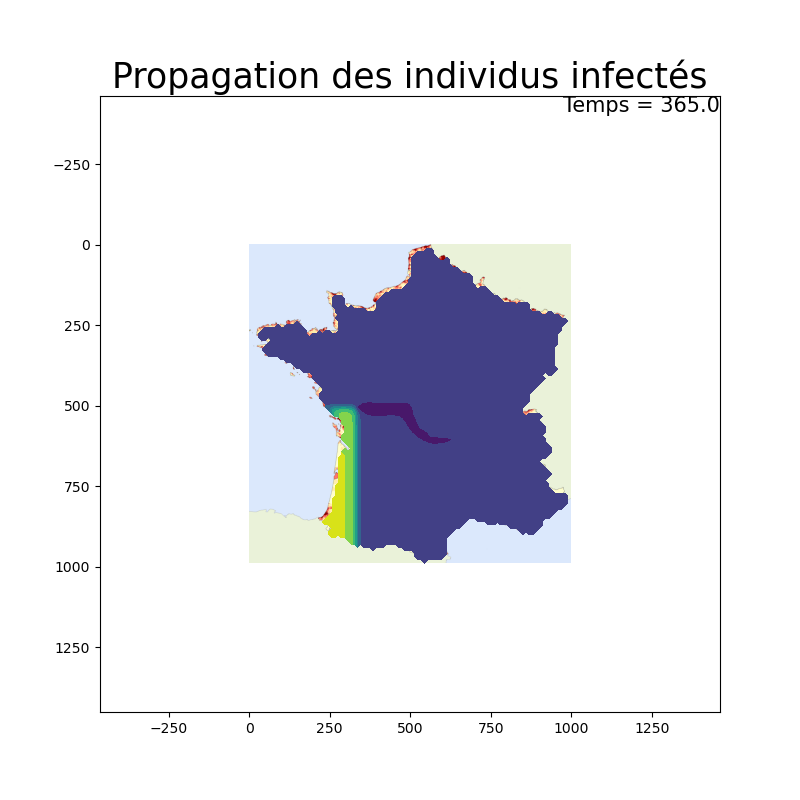

<ipython-input-6-2be21469d9e3>:142: RuntimeWarning: invalid value encountered in true_divide
  dudt[:,0]=np.multiply(-beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)+delta*u[:,sys_size-1]
<ipython-input-6-2be21469d9e3>:143: RuntimeWarning: invalid value encountered in true_divide
  dudt[:,1]=np.multiply(beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)-gamma*u[:,1]


In [6]:
## COVID-19 epidemiological reaction-diffusion model

#Paramètres des équations
DS = 0
DI = 8
DR = 0

beta_0=0.8
theta=0.5
gamma=0.5
delta=0.9


f1 = h5py.File('grid_2.hdf5', 'r')
J1=f1['J1'][0][0]
J2=f1['J2'][0][0]
border=f1['border'][0][:]
interior=f1['interior'][0][:]

f1.close()

# Simulation parameters 
# The grid has J2 points (in x) by J1 points (in y)
# The French map:
# width: 874 px and 175 px = 200km -> 874 px = 998 km 
# h = 998 km / (J1-1)
# Space units: km 
S  = 998.0;                         # space scale factor;
h1 = 998/(J2-1);                    # grid square size
h2 = 988.12/(J1-1);                 # grid square size
h=S/(J2-1)                          # grid square size
x = h1*np.arange(0,J2)              # space discretisation in x
y = h2*np.arange(0,J1)              # space discretisation in y
[X,Y] = np.meshgrid(x,y)            # matrix version of (x,y) for plotting purpose
J  = J1*J2;                         # grid size 
ymax = 3000

exterior = np.setdiff1d(np.arange(0,J),np.unique(np.concatenate((border,interior))))

[exterior_x,exterior_y]=np.unravel_index(exterior, (J1,J2),order='F')
X[exterior_x,exterior_y] = float('nan')
Y[exterior_x,exterior_y] = float('nan')


# Variables dynamiques
sys_size = 12
u = sparse.csc_matrix((J,sys_size)) 
newu = sparse.csc_matrix((J,sys_size)) 
u12 = sparse.csc_matrix((J,sys_size))
dudt = sparse.csc_matrix((J,sys_size)) 

# Fill regions and cities with susceptible and infected
u[:,0] = 60
u[:,1] = 0
u[:,2:sys_size] = 0

#On va mettre des infectés dans l'Ouest
u[0:int(J/3),1]=10


exteriorX = np.ravel_multi_index(np.array([exterior_x,exterior_y]), (J1,J2),order='F')
u[exteriorX,:]= 0 #float('nan')
N=np.sum(u,axis=1).reshape((J,1))

mask1= (X - 600)**2 + (Y - 500)**2 < 100**2
mask1=mask1.reshape(J,order='F')
mask2=np.arange(0,int(J/2))
[a_x,a_y]=np.unravel_index(mask2, (J1,J2))
mask2 = np.ravel_multi_index(np.array([a_x,a_y]), (J1,J2),order='F')
u[mask1,1]=0
u[mask2,1]=0
# Diffusion coefficient matrix
D_diag=y0=np.concatenate((np.array([DS,DI]),np.repeat(DR,sys_size-2)))
D=sparse.dia_matrix((D_diag,0),(sys_size,sys_size))

# Paramètres temporels
t0     = 0.0
tfinal = 365 
dt     = 0.1
t      = t0+dt


u_out = np.reshape(u[:,1].toarray(),(J1,J2),order='F')
u_out[u_out < 0.005] = float('nan') 
#u_out[0,0] = 100 # pour que l'affichage ne change pas de couleur entre chaque mise à jour !


plt.ion()
figure, ax = plt.subplots(figsize=(8,8))
I = PIL.Image.open('France_population_density_2.png') 
T = np.array(I)
plt.imshow(T,extent=(0, 998, 988.12, 0)) 
plt.axis('equal')

line1 = ax.contourf(X,Y, u_out,alpha=1)
#figure.colorbar(line1)
text="Temps = "+str(t)
line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
plt.title("Propagation des individus infectés",fontsize=25)

figure.canvas.draw()
figure.canvas.flush_events()
titre="SIR10S_beta_non_constant_1/" + text + ".png"
plt.savefig(titre,dpi=300)


# Densités totales
tt = np.arange(0,tfinal,dt)
utot = np.zeros((np.size(tt),sys_size))
utot[0,:] = np.sum(u[interior,:],axis=0)*h**2
vi = 1;

## ADI's Crank-Nicolson implicit schemes 
ASx = sparse.eye(J)-dt/h**2*DS/2*Lx
AIx = sparse.eye(J)-dt/h**2*DI/2*Lx
ARx = sparse.eye(J)-dt/h**2*DR/2*Lx

ASy = sparse.eye(J)-dt/h**2*DS/2*Ly
AIy = sparse.eye(J)-dt/h**2*DI/2*Ly
ARy = sparse.eye(J)-dt/h**2*DR/2*Ly


# Neumann no flux conditions: compute (approximate) boundary normal vector 
normal = np.zeros(np.size(border));
for i in range(np.size(border)):
    if any(interior == border[i]+1):     # normal up ^ 
        normal[i] = 1
    elif any(interior == border[i]-1):   # normal down v 
        normal[i] = 3
    elif any(interior == border[i]-J1):  # normal right >
        normal[i] = 2
    elif any(interior == border[i]+J1):  # normal left <
        normal[i] = 4
    else:
        normal[i] = -1

## MAIN LOOP        
while t < tfinal:
    N=np.sum(u,1)
    #Pas 1
    beta_I=beta_0*(u[:,1]/(theta+u[:,1].toarray()))
    dudt[:,0]=np.multiply(-beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)+delta*u[:,sys_size-1]
    dudt[:,1]=np.multiply(beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)-gamma*u[:,1]
    dudt[:,2]=gamma*u[:,1]-delta*u[:,2]
    dudt[:,3:sys_size]=delta*u[:,2:sys_size-1]-delta*u[:,3:sys_size]

    
    b = ( u + dt/2 * dudt + dt/2/h**2*Ly*u*D )
    b=sparse.csc_matrix(np.reshape(np.transpose(np.reshape(b.toarray(),(J1,J2,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F'))
    
    u12=sparse.csc_matrix((J,sys_size))
    u12[:,0] = sparse.linalg.spsolve(ASx,b[:,0]).reshape(J,1)
    u12[:,1] = sparse.linalg.spsolve(AIx,b[:,1]).reshape(J,1)
    u12[:,2:sys_size] = sparse.linalg.spsolve(ARx,b[:,2:sys_size]).reshape(J,sys_size-2)
    Lxu12=np.dot(Lx,u12)

    #Pas 2
    
    u12=np.reshape(np.transpose(np.reshape(u12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    Lxu12=np.reshape(np.transpose(np.reshape(Lxu12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    
    N=np.sum(u12,1).reshape(J,1)
    beta_I=beta_0*(u12[:,1]/(theta+u12[:,1]))
    dudt[:,0] = (-beta_I*u12[:,0]*u12[:,1]/np.sum(u12,1)).reshape(J,1)+delta*u12[:,sys_size-1].reshape(J,1)
    dudt[:,1] = (beta_I*u12[:,0]*u12[:,1]/np.sum(u12,1)).reshape(J,1) - gamma*u12[:,1].reshape(J,1)
    dudt[:,2]=(gamma*u12[:,1]-delta*u12[:,2]).reshape(J,1)
    dudt[:,3:sys_size]=(delta*u12[:,2:sys_size-1]-delta*u12[:,3:sys_size]).reshape(J,sys_size-3)

    b = u12 + dt/2 * dudt + dt/2/h**2*Lxu12*D

    newu[:,0] = sparse.linalg.spsolve(ASy,b[:,0]).reshape(J,1)
    newu[:,1] = sparse.linalg.spsolve(AIy,b[:,1]).reshape(J,1)
    newu[:,2:sys_size] = sparse.linalg.spsolve(ARy,b[:,2:sys_size]).reshape(J,sys_size-2)

    # Neumann no flux
    for i in range(np.size(border)):
        if ( normal[i] == 1 ):
            newu[border[i],:] = newu[border[i]+1,:]  
        elif ( normal[i] == 2 ):
            newu[border[i],:] = newu[border[i]-J1,:]  
        elif ( normal[i] == 3 ):
            newu[border[i],:] = newu[border[i]-1,:]  
        elif ( normal[i] == 4 ):
            newu[border[i],:] = newu[border[i]+J1,:]  
        else:
            newu[border[i],:] = float('nan')
    
    u=newu.copy()
    if t<120: 
        u[mask1,1]=0
        u[mask2,1]=0
    u_out = np.reshape(u[:,1],(J1,J2),order='F').toarray()
    
    utot[vi,:] = np.sum(u[interior,:],axis=0)*h**2
    u_out[u_out < 0.005] = float('nan')
    #u_out[0,0] = 50
    t = np.round(t + dt,1)
    vi = vi + 1
    plt.cla()
    plt.imshow(T,extent=(0, 998, 988.12, 0)) 
    plt.axis('equal')
    line1 = ax.contourf(X,Y,u_out,alpha=1)
    text="Temps = "+str(t)
    line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
    plt.title("Propagation des individus infectés",fontsize=25)
    figure.canvas.draw()
    figure.canvas.flush_events()
    titre="SIR10S_beta_non_constant_1/" + text + ".png"
    plt.savefig(titre,dpi=300)

# Modèle $SIR_{10}S$ avec $\beta(I)=\frac{I^2}{\theta+I}$

<IPython.core.display.Javascript object>


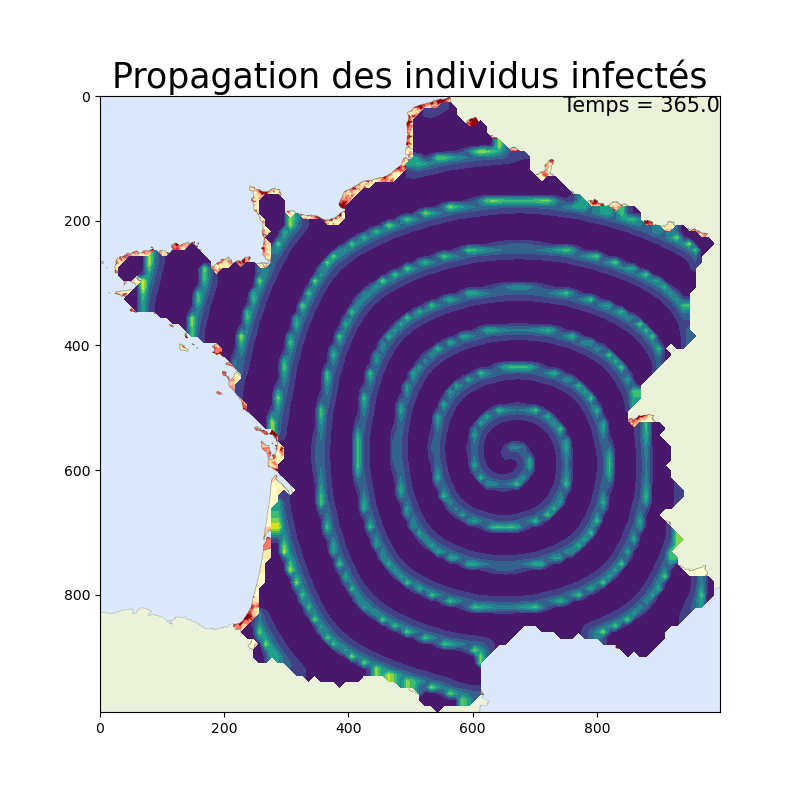

<ipython-input-4-9979672ae1ec>:141: RuntimeWarning: invalid value encountered in true_divide
  dudt[:,0]=np.multiply(-beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)+delta*u[:,sys_size-1]
<ipython-input-4-9979672ae1ec>:142: RuntimeWarning: invalid value encountered in true_divide
  dudt[:,1]=np.multiply(beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)-gamma*u[:,1]


In [4]:
## COVID-19 epidemiological reaction-diffusion model

#Paramètres des équations
DS = 0
DI = 8
DR = 0

beta_0=0.8
theta=0.5
gamma=0.5
delta=0.9


f1 = h5py.File('grid_2.hdf5', 'r')
J1=f1['J1'][0][0]
J2=f1['J2'][0][0]
border=f1['border'][0][:]
interior=f1['interior'][0][:]

f1.close()

# Simulation parameters 
# The grid has J2 points (in x) by J1 points (in y)
# The French map:
# width: 874 px and 175 px = 200km -> 874 px = 998 km 
# h = 998 km / (J1-1)
# Space units: km 
S  = 998.0;                         # space scale factor;
h1 = 998/(J2-1);                    # grid square size
h2 = 988.12/(J1-1);                 # grid square size
h=S/(J2-1)                          # grid square size
x = h1*np.arange(0,J2)              # space discretisation in x
y = h2*np.arange(0,J1)              # space discretisation in y
[X,Y] = np.meshgrid(x,y)            # matrix version of (x,y) for plotting purpose
J  = J1*J2;                         # grid size 
ymax = 3000

exterior = np.setdiff1d(np.arange(0,J),np.unique(np.concatenate((border,interior))))

[exterior_x,exterior_y]=np.unravel_index(exterior, (J1,J2),order='F')
X[exterior_x,exterior_y] = float('nan')
Y[exterior_x,exterior_y] = float('nan')


# Variables dynamiques
sys_size = 12
u = sparse.csc_matrix((J,sys_size)) 
newu = sparse.csc_matrix((J,sys_size)) 
u12 = sparse.csc_matrix((J,sys_size))
dudt = sparse.csc_matrix((J,sys_size)) 

# Fill regions and cities with susceptible and infected
u[:,0] = 60
u[:,1] = 0
u[:,2:sys_size] = 0

#On va mettre des infectés dans l'Ouest
u[0:int(J/3),1]=10


exteriorX = np.ravel_multi_index(np.array([exterior_x,exterior_y]), (J1,J2),order='F')
u[exteriorX,:]= 0 #float('nan')
N=np.sum(u,axis=1).reshape((J,1))

mask1= (X - 600)**2 + (Y - 500)**2 < 100**2
mask1=mask1.reshape(J,order='F')
mask2=np.arange(0,int(J/2))
[a_x,a_y]=np.unravel_index(mask2, (J1,J2))
mask2 = np.ravel_multi_index(np.array([a_x,a_y]), (J1,J2),order='F')
u[mask1,1]=0
u[mask2,1]=0
# Diffusion coefficient matrix
D_diag=y0=np.concatenate((np.array([DS,DI]),np.repeat(DR,sys_size-2)))
D=sparse.dia_matrix((D_diag,0),(sys_size,sys_size))

# Paramètres temporels
t0     = 0.0
tfinal = 365 
dt     = 0.1
t      = t0+dt


u_out = np.reshape(u[:,1].toarray(),(J1,J2),order='F')
u_out[u_out < 0.005] = float('nan') 
#u_out[0,0] = 100 # pour que l'affichage ne change pas de couleur entre chaque mise à jour !


plt.ion()
figure, ax = plt.subplots(figsize=(8,8))
I = PIL.Image.open('France_population_density_2.png') 
T = np.array(I)
plt.imshow(T,extent=(0, 998, 988.12, 0)) 
plt.axis('equal')

line1 = ax.contourf(X,Y, u_out,alpha=1)
#figure.colorbar(line1)
text="Temps = "+str(t)
line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
plt.title("Propagation des individus infectés",fontsize=25)

figure.canvas.draw()
figure.canvas.flush_events()
titre="SIR10S_beta_non_constant_3/" + text + ".png"
plt.savefig(titre,dpi=300)

# Densités totales
tt = np.arange(0,tfinal,dt)
utot = np.zeros((np.size(tt),sys_size))
utot[0,:] = np.sum(u[interior,:],axis=0)*h**2
vi = 1;

## ADI's Crank-Nicolson implicit schemes 
ASx = sparse.eye(J)-dt/h**2*DS/2*Lx
AIx = sparse.eye(J)-dt/h**2*DI/2*Lx
ARx = sparse.eye(J)-dt/h**2*DR/2*Lx

ASy = sparse.eye(J)-dt/h**2*DS/2*Ly
AIy = sparse.eye(J)-dt/h**2*DI/2*Ly
ARy = sparse.eye(J)-dt/h**2*DR/2*Ly


# Neumann no flux conditions: compute (approximate) boundary normal vector 
normal = np.zeros(np.size(border));
for i in range(np.size(border)):
    if any(interior == border[i]+1):     # normal up ^ 
        normal[i] = 1
    elif any(interior == border[i]-1):   # normal down v 
        normal[i] = 3
    elif any(interior == border[i]-J1):  # normal right >
        normal[i] = 2
    elif any(interior == border[i]+J1):  # normal left <
        normal[i] = 4
    else:
        normal[i] = -1

## MAIN LOOP        
while t < tfinal:
    N=np.sum(u,1)
    #Pas 1
    beta_I=beta_0*(u[:,1].toarray()**2/(theta+u[:,1].toarray()))
    dudt[:,0]=np.multiply(-beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)+delta*u[:,sys_size-1]
    dudt[:,1]=np.multiply(beta_I,u[:,0].toarray(),u[:,1].toarray())/np.sum(u,1)-gamma*u[:,1]
    dudt[:,2]=gamma*u[:,1]-delta*u[:,2]
    dudt[:,3:sys_size]=delta*u[:,2:sys_size-1]-delta*u[:,3:sys_size]

    
    b = ( u + dt/2 * dudt + dt/2/h**2*Ly*u*D )
    b=sparse.csc_matrix(np.reshape(np.transpose(np.reshape(b.toarray(),(J1,J2,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F'))
    
    u12=sparse.csc_matrix((J,sys_size))
    u12[:,0] = sparse.linalg.spsolve(ASx,b[:,0]).reshape(J,1)
    u12[:,1] = sparse.linalg.spsolve(AIx,b[:,1]).reshape(J,1)
    u12[:,2:sys_size] = sparse.linalg.spsolve(ARx,b[:,2:sys_size]).reshape(J,sys_size-2)
    Lxu12=np.dot(Lx,u12)

    #Pas 2
    
    u12=np.reshape(np.transpose(np.reshape(u12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    Lxu12=np.reshape(np.transpose(np.reshape(Lxu12.toarray(),(J2,J1,sys_size),order='F'),(1,0,2)),(J,sys_size),order='F')
    
    N=np.sum(u12,1).reshape(J,1)
    beta_I=beta_0*(u12[:,1]**2/(theta+u12[:,1]))
    dudt[:,0] = (-beta_I*u12[:,0]*u12[:,1]/np.sum(u12,1)).reshape(J,1)+delta*u12[:,sys_size-1].reshape(J,1)
    dudt[:,1] = (beta_I*u12[:,0]*u12[:,1]/np.sum(u12,1)).reshape(J,1) - gamma*u12[:,1].reshape(J,1)
    dudt[:,2]=(gamma*u12[:,1]-delta*u12[:,2]).reshape(J,1)
    dudt[:,3:sys_size]=(delta*u12[:,2:sys_size-1]-delta*u12[:,3:sys_size]).reshape(J,sys_size-3)

    b = u12 + dt/2 * dudt + dt/2/h**2*Lxu12*D

    newu[:,0] = sparse.linalg.spsolve(ASy,b[:,0]).reshape(J,1)
    newu[:,1] = sparse.linalg.spsolve(AIy,b[:,1]).reshape(J,1)
    newu[:,2:sys_size] = sparse.linalg.spsolve(ARy,b[:,2:sys_size]).reshape(J,sys_size-2)

    # Neumann no flux
    for i in range(np.size(border)):
        if ( normal[i] == 1 ):
            newu[border[i],:] = newu[border[i]+1,:]  
        elif ( normal[i] == 2 ):
            newu[border[i],:] = newu[border[i]-J1,:]  
        elif ( normal[i] == 3 ):
            newu[border[i],:] = newu[border[i]-1,:]  
        elif ( normal[i] == 4 ):
            newu[border[i],:] = newu[border[i]+J1,:]  
        else:
            newu[border[i],:] = float('nan')
    
    u=newu.copy()
    if t<60: 
        u[mask1,1]=0
        u[mask2,1]=0
    u_out = np.reshape(u[:,1],(J1,J2),order='F').toarray()
    
    utot[vi,:] = np.sum(u[interior,:],axis=0)*h**2
    u_out[u_out < 0.005] = float('nan')
    #u_out[0,0] = 50
    t = np.round(t + dt,1)
    vi = vi + 1
    plt.cla()
    plt.imshow(T,extent=(0, 998, 988.12, 0)) 
    plt.axis('equal')
    line1 = ax.contourf(X,Y,u_out,alpha=1)
    text="Temps = "+str(t)
    line2=ax.text(1, 1,text,horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,size=15)
    plt.title("Propagation des individus infectés",fontsize=25)
    figure.canvas.draw()
    figure.canvas.flush_events()
    titre="SIR10S_beta_non_constant_3/" + text + ".png"
    plt.savefig(titre,dpi=300)